In [17]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===== CONFIGURATION SECTION =====
# Just paste your values here and run!

# Main project configuration
PROJECT_NAME = "multiturn_island"  # Paste your project name here
ENTITY = None  # Set to your wandb entity if needed

# Run naming patterns - modify these to match your runs
PENALTY_RUN_PATTERN = "penalty"  # Runs with penalty (e.g., "acre-63", "acre-64")
NO_PENALTY_RUN_PATTERN = "no_penalty"  # Runs without penalty
SPLIT_SHOG_RUN_PATTERN = "severed_shog"  # Split model runs (set to None to exclude)
SHOGGOTH_RUN_PATTERN = "shoggoth"  # Shog runs (set to None to exclude)

# ===== END CONFIGURATION =====

# Initialize wandb API and load data
api = wandb.Api()
project_path = f"{ENTITY}/{PROJECT_NAME}" if ENTITY else PROJECT_NAME

print(f"Loading runs from project: {project_path}")
runs = api.runs(project_path)
print(f"Found {len(runs)} total runs")


Loading runs from project: multiturn_island
Found 219 total runs


In [16]:
# Define the earliest run name to include (by datetime, not by name)
FIRST_RUN_NAME = "shoggoth-17"  # Only include runs as least as recent as this run (by datetime)

# Find the datetime of the FIRST_RUN_NAME run
first_run_datetime = None
for run in runs:
    if run.name == FIRST_RUN_NAME:
        first_run_datetime = run.created_at
        break

if first_run_datetime is None:
    raise ValueError(f"Could not find a run with name {FIRST_RUN_NAME} to determine recency cutoff.")

# Filter runs from main project by datetime
filtered_runs = []
for run in runs:
    if not run.name:
        continue
    # Only include runs created at or after the FIRST_RUN_NAME run
    if run.created_at >= first_run_datetime:
        filtered_runs.append(run)

print(f"Found {len(filtered_runs)} matching runs from  project")

# Load data for filtered runs
run_data = []
for run in filtered_runs:
    history = run.history()
    if len(history) > 0:  # Only include runs with data
        run_data.append({
            'name': run.name,
            'config': run.config,
            'history': history,
            'state': run.state
        })

print(f"Loaded data for {len(run_data)} runs with metrics")


Found 80 matching runs from  project
Loaded data for 80 runs with metrics


Plotting 75 runs
Categories: {'No Penalty': 31, 'Severed Mind+Face': 24, 'Mind+Face': 10, 'Penalty': 10}


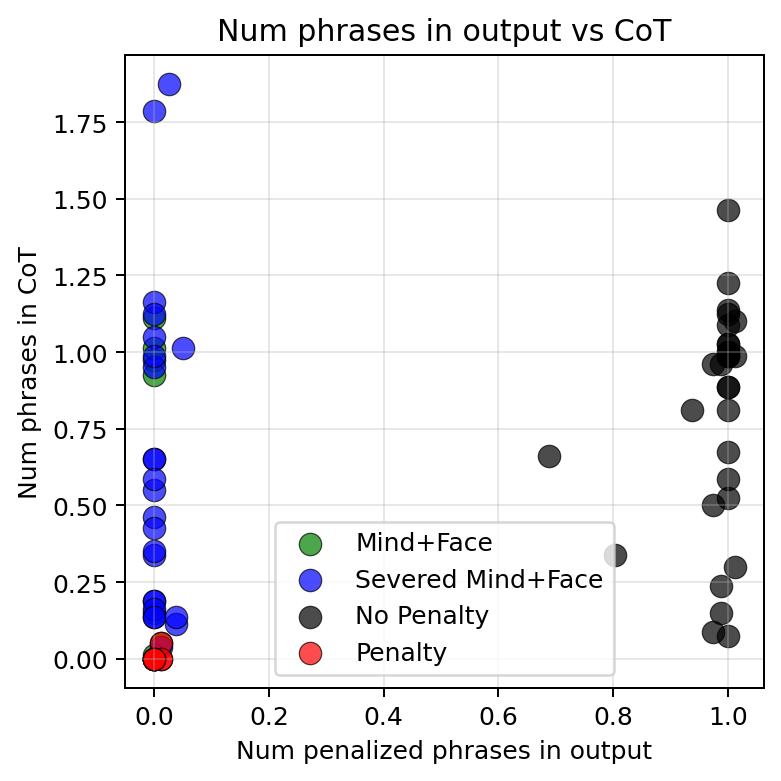

In [20]:
# Generate scatterplot
scatter_data = []

for run_info in run_data:
    history = run_info['history']
    name = run_info['name']
    config = run_info['config']
    
    # Check if we have the required columns
    if 'word_count_output' in history.columns and 'word_count_cot' in history.columns:
        # Use last 10 steps for averaging (excluding the very last step)
        num_steps = min(10, len(history) - 1)
        if num_steps > 0:
            final_steps = history.iloc[-num_steps-1:-1] if len(history) > num_steps else history.iloc[:-1]
            
            if len(final_steps) > 0:
                avg_output_words = final_steps['word_count_output'].mean()
                avg_thinking_words = final_steps['word_count_cot'].mean()
                
                # Categorize runs based on patterns
                if SPLIT_SHOG_RUN_PATTERN in name:
                    category = 'Severed Mind+Face'
                    color = 'blue'
                elif SHOGGOTH_RUN_PATTERN in name:
                    category = 'Mind+Face'
                    color = 'green'
                elif NO_PENALTY_RUN_PATTERN in name:
                    category = 'No Penalty'
                    color = 'black'
                elif PENALTY_RUN_PATTERN in name:
                    category = 'Penalty'
                    color = 'red'
                else:
                    # Do not display "Other" runs
                    continue
                
                scatter_data.append({
                    'name': name,
                    'output_words': avg_output_words,
                    'thinking_words': avg_thinking_words,
                    'category': category,
                    'color': color
                })

# Create scatter plot
scatter_df = pd.DataFrame(scatter_data)
print(f"Plotting {len(scatter_df)} runs")
if len(scatter_df) > 0:
    print(f"Categories: {scatter_df['category'].value_counts().to_dict()}")

# Configure figure size and DPI like the original notebook
IMG_SIZE_REDUCE = 1.8  # Factor to reduce image size and increase dpi
orig_figsize = (8, 8)
reduced_figsize = (orig_figsize[0] / IMG_SIZE_REDUCE, orig_figsize[1] / IMG_SIZE_REDUCE)
dpi = 100 * IMG_SIZE_REDUCE

plt.figure(figsize=reduced_figsize, dpi=dpi)
for category in scatter_df['category'].unique():
    category_data = scatter_df[scatter_df['category'] == category]
    plt.scatter(
        category_data['output_words'], 
        category_data['thinking_words'],
        c=category_data['color'].iloc[0],
        alpha=0.7,
        s=80,
        label=category,
        edgecolors='black',
        linewidth=0.5
    )

plt.xlabel('Num penalized phrases in output')
plt.ylabel('Num phrases in CoT')
plt.title('Num phrases in output vs CoT')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Plot histograms of the number of phrases in CoT for "Severed Mind+Face", "Mind+Face", and "Penalty" runs
categories = ["No Penalty", "Severed Mind+Face", "Mind+Face", "Penalty"]
n_categories = len(categories)

# Get the color for each category from the dataframe (first occurrence)
category_colors = {}
for cat in categories:
    cat_rows = scatter_df[scatter_df['category'] == cat]
    if not cat_rows.empty:
        category_colors[cat] = cat_rows['color'].iloc[0]
    else:
        category_colors[cat] = 'gray'  # fallback color if category not found

# Find the global min and max for x-axis range
all_thinking_words = pd.concat([scatter_df[scatter_df['category'] == cat]['thinking_words'] for cat in categories])
x_min = all_thinking_words.min()
x_max = all_thinking_words.max()

# Compute bin edges so that all subplots use the same bins
bins = np.linspace(x_min, x_max, 11)  # 10 bins => 11 edges

# Find the global max count for y-axis range
max_counts = []
for cat in categories:
    cat_df = scatter_df[scatter_df['category'] == cat]
    counts, _ = np.histogram(cat_df['thinking_words'], bins=bins)
    max_counts.append(counts.max() if len(counts) > 0 else 0)
y_max = max(max_counts) if max_counts else None

# 2x2 subplot arrangement
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
fig.suptitle("Num Penalized Words in CoT", fontsize=16)

for idx, cat in enumerate(categories):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    cat_df = scatter_df[scatter_df['category'] == cat]
    ax.hist(
        cat_df['thinking_words'],
        bins=bins,
        color=category_colors[cat],
        edgecolor='black',
        alpha=0.8
    )
    ax.set_ylabel('Count')
    ax.set_title(cat)
    ax.grid(axis='y', alpha=0.3)
    ax.set_xlim(x_min, x_max)
    if y_max is not None:
        ax.set_ylim(0, y_max)

# Set xlabel only on bottom row
for col in range(2):
    axes[1, col].set_xlabel('Num penalized words in CoT')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
